# PHRAIME (Klebsiella)

An AI-based Phage-Host interaction predictor framework with receptors and receptor-binding proteins at its core. This particular PHRAIME is for *Klebsiella pneumoniae* related phages.

This notebook follows after having ran the PhageHostPredict_processing steps implemented in the accompanying Python script.

The predictive framework works as follows:

1. [Transform the locus into an embedding using Word2Vec](#locusembed)
3. [Transform the RBP sequence into an embedding](#rbpembed) using UniRep, ProtTransBert, SeqVec, ...
3. [Exploring the interactions space](#interactions) for insight and further improvement
4. [Concatenate and train an RF model](#models) via cross-validation

## 0 - Libraries and directories

In [1]:
import os
import math
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
#from bio_embeddings.embed import Word2VecEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder
%matplotlib inline

In [2]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
klebsiella_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Klebsiella_RBP_data'
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

## 1 - Transform locus into embeddings<a name="locusembed"></a>

In [13]:
def locus_embeddings(kaptive_file_names, data_dir):
    """
    This functions computes Word2Vec embeddings for bacterial genomic loci. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of bacterial loci into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU can be slow (not advised). Best to start a Google
    Colab notebook and run the computations in the cloud.
    
    Input:
    - kaptive_file_names: list of fasta filenames of bacterial loci (output of Kaptive)
    - data_dir: location of the sequence file(s) to loop over
    - results_dir: directory to store the resulting embeddings in.
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = Word2VecEmbedder()
    embeddings_list = []

    for name in tqdm(kaptive_file_names):
        locus_sequence = ''
        # one or multiple records in fasta file
        for record in SeqIO.parse(data_dir+'/'+name, 'fasta'):
            locus_sequence += str(record.seq)
        
        # compute embedding
        embedding = embedder.embed(locus_sequence)
        reduced_embedding = embedder.reduce_per_protein(embedding)
        embeddings_list.append(reduced_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame(kaptive_file_names), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(data_dir+'/locus_embeddings.csv', index=False)
    
    return      

In [14]:
genomes = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221.csv')
kaptive_file_names = pu.get_kaptive_file_names(genomes)
locus_embeddings(names, klebsiella_dir, klebsiella_dir)

100%|██████████| 376/376 [00:29<00:00, 12.69it/s]


## 2 - Tranform RBP sequences into embeddings <a name="rbpembed"></a>

In [36]:
def protein_embeddings_df(dataframe, results_dir):
    """
    This functions computes ProttransBERT embeddings protein sequences in a dataframe. It uses the bio-embeddings
    package together with BioPython to transform fasta sequences of phage RBPs into numerical embeddings.
    
    WARNING: running this on a personal laptop without GPU is very slow and not advised. Best to start a Google
    Collab notebook and run the computations in the cloud 
    
    Input:
    - dataframe: RBPbase, columns 'protein_seq', 'unique_ID'
    - results_dir: directory to store the resulting embeddings in
    
    Output:
    - embeddings: Pandas DataFrame (as .csv file) with file names and their corresponding embedding
    """
    embedder = ProtTransBertBFDEmbedder()
    id_list = []
    embeddings_list = []
    pb = tqdm(total=dataframe.shape[0])

    for i, sequence in enumerate(dataframe['protein_seq']):
        id_list.append(dataframe['unique_ID'][i])
        embedding = embedder.embed(sequence)
        reduced_embedding = embedder.reduce_per_protein(embedding)
        embeddings_list.append(reduced_embedding)
        pb.update(1)
    pb.close()
    
    embeddings_df = pd.concat([pd.DataFrame(id_list), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(results_dir+'/RBPbase_031221_klebsiella_pneumoniae_embeddings.csv', index=False)
    
    return

In [65]:
#protein_embeddings(rbp_file_names, data_dir) # do in Google Colab or Kaggle

## 4 - Construct reliable negative interactions <a name="neginteractions"></a>

## 5 - Exploring the interaction space<a name="interactions"></a>

#### How many RBPs do phages have?

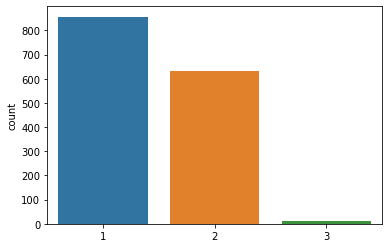

In [19]:
rbpbase = pd.read_csv(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.csv')
rbp_counts = []
for phage in rbpbase['phage_nr']:
    rbp_counts.append(list(rbpbase['phage_nr']).count(phage))
ax = sns.countplot(x = rbp_counts)

We see that most Klebsiella phages either have one RBP or two RBPs. Due to the nature of our RBP identification, we might have missed some RBPs though.

#### Can we discriminate B-helix phages using SPIDER-3?

First move all the KP32 RBP sequences in the ./example_data/seq/ folder in SPIDER3-S. Then write/adjust the file_list with all the names of the sequences you want to make predictions for.

In [3]:
# write klebs rbp files & adjust file_list for SPIDER3-S
spider_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S'
klebs_rbps = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Klebsiella_RBP_data/sequences/klebsiella_RBPs.fasta'
file_list = open(spider_dir+'/file_list', 'w')
kpids = []
for record in SeqIO.parse(klebs_rbps, 'fasta'):
    identifier = record.id
    kpids.append(identifier)
    sequence = str(record.seq)
    
    # write fasta
    fasta = open(spider_dir+'/example_data/seq/klebs_rbp_'+identifier+'.fasta', 'w')
    fasta.write('>'+identifier+'\n'+sequence+'\n')
    fasta.close()
    
    # write file_list
    file_list.write(identifier+' '+'./example_data/seq/klebs_rbp_'+identifier+'.fasta'+'\n')
file_list.close()

In [2]:
# compute KP32 secondary structures
spider_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S'
command = 'cd '+spider_dir+ '; ./impute_script_np.sh'
ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
ssout, sserr = ssprocess.communicate()
print(ssout)

b'doing iteration 0 - SS\ndoing iteration 0 - ASA THETA TAU PHI PSI HSEa CN\ncombining both prediction files\ndoing iteration 1 - SS\ndoing iteration 1 - ASA THETA TAU PHI PSI HSEa CN\ncombining both prediction files\nTime taken - 90 seconds\n'


In [5]:
B_ratio = []
for identifier in kpids:
    results = pd.read_csv('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S/example_data/outputs/'+identifier+'.i1', delim_whitespace=True, header=0)
    sstructs = ''.join([i for i in results['SS']])
    B_ratio.append(sstructs.count('E')/len(sstructs))

Text(0, 0.5, 'Count among klebsiella RBPs')

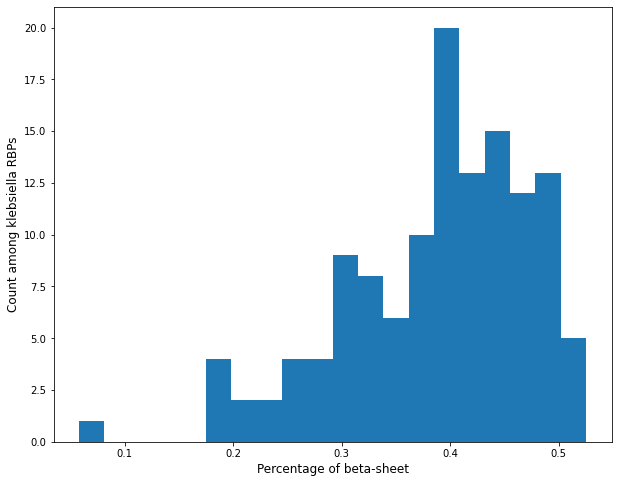

In [118]:
fig, ax = plt.subplots(figsize=(10, 8))
n, bins, patches = plt.hist(B_ratio, bins=20)
ax.set_xlabel('Percentage of beta-sheet', size=12)
ax.set_ylabel('Count among klebsiella RBPs', size=12)

We can see that most Klebsiella RBPs with a B-helix have a beta-sheet percentage of 30% or higher.

In [121]:
# Now do the same for all klebs RBPs in RBPbase
spider_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S'
rbpbase = pd.read_csv(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.csv')
file_list = open(spider_dir+'/file_list', 'w')
kpids = []
for i, sequence in enumerate(rbpbase['protein_seq']):
    identifier = rbpbase['unique_ID'][i]
    kpids.append(identifier)

    # write fasta
    fasta = open(spider_dir+'/example_data/seq/rbpbase_'+identifier+'.fasta', 'w')
    fasta.write('>'+identifier+'\n'+sequence+'\n')
    fasta.close()
    
    # write file_list
    file_list.write(identifier+' '+'./example_data/seq/rbpbase_'+identifier+'.fasta'+'\n')
file_list.close()

In [122]:
# compute KP32 secondary structures -> WILL TAKE ABOUT 100 minutes
command = 'cd '+spider_dir+ '; ./impute_script_np.sh'
ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
ssout, sserr = ssprocess.communicate()
print(ssout)

B_ratio = []
for identifier in kpids:
    results = pd.read_csv('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S/example_data/outputs/'+identifier+'.i1', delim_whitespace=True, header=0)
    sstructs = ''.join([i for i in results['SS']])
    B_ratio.append(sstructs.count('E')/len(sstructs))

b'doing iteration 0 - SS\ndoing iteration 0 - ASA THETA TAU PHI PSI HSEa CN\ncombining both prediction files\ndoing iteration 1 - SS\ndoing iteration 1 - ASA THETA TAU PHI PSI HSEa CN\ncombining both prediction files\nTime taken - 3282 seconds\n'


Text(0, 0.5, 'Count among klebsiella RBPs')

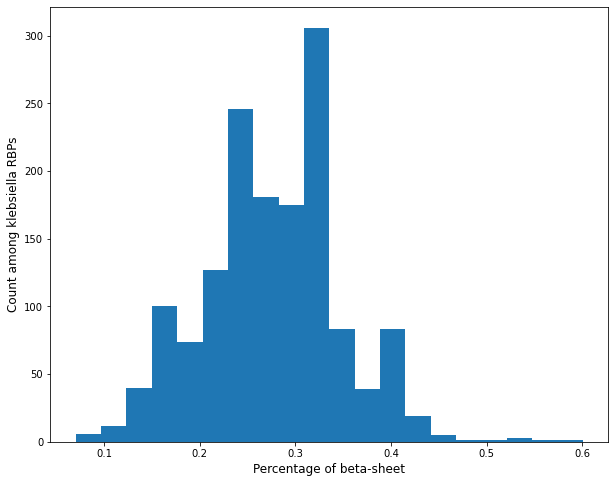

In [124]:
fig, ax = plt.subplots(figsize=(10, 8))
n, bins, patches = plt.hist(B_ratio, bins=20)
ax.set_xlabel('Percentage of beta-sheet', size=12)
ax.set_ylabel('Count among klebsiella RBPs', size=12)
#ax.axvline(x=0.3, color='red')

#### Implementing moving average for B-helix detection

In [8]:
def moving_average_SS(sequence, window_size=33):
    mas = []
    window_bit = int((window_size-1)/2)

    # compute margins outside of the window
    for i, character in enumerate(['H', 'E', 'C']):
        first_slice = sequence[:window_size]
        moving_average = np.zeros((len(sequence)))
        moving_average[:window_bit] = first_slice.count(character) / window_size
        last_slice = sequence[len(sequence)-window_size:]
        moving_average[len(sequence)-window_bit:] = last_slice.count(character) / window_size

        # sliding window
        for i in range(int(window_bit), int(len(sequence)-window_bit)):
            slice = sequence[int(i-window_bit):int(i+window_bit+1)]
            moving_average[i] = slice.count(character) / window_size
        mas.append(moving_average)
            
    return mas[0], mas[1], mas[2]

In [26]:
KP32s = ['ALT58497.1', 'ALT58498.1', 'YP_009198668.1', 'YP_009198669.1', 'APZ82804.1', 'APZ82805.1', 'APZ82847.1', 'APZ82848.1', 
'YP_002003830.1', 'YP_002003831.1', 'AWN07083.1', 'AWN07084.1', 'AWN07125.1', 'AWN07126.1', 'AWN07172.1', 'AWN07213.1', 'AWN07214.1', 
'YP_003347555.1', 'YP_003347556.1', 'YP_009215498.1', 'AOT28172.1', 'AOT28173.1', 'AOZ65569.1', 'AUV61507.1']
ma_B = []
ma_H = []
ma_C = []

for i, kp32 in enumerate(KP32s):
    results = pd.read_csv('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/SPIDER3-S/example_data/outputs/'+kp32+'.i1', delim_whitespace=True, header=0)
    sstructs = ''.join([x for x in results['SS']])
    maHc, maBc, maCc = moving_average_SS(sstructs, window_size=50)
    ma_H.append(maHc)
    ma_B.append(maBc)
    ma_C.append(maCc)

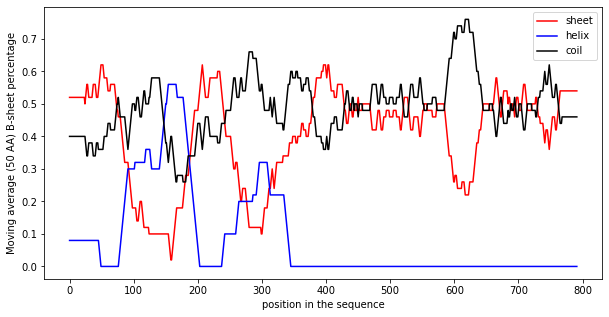

In [34]:
index = 4
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('position in the sequence')
ax.set_ylabel('Moving average (50 AA) B-sheet percentage')
ax.plot(ma_B[index], c='red', label='sheet')
ax.plot(ma_H[index], c='blue', label='helix')
ax.plot(ma_C[index], color='black', label='coil')
ax.legend()
fig.savefig('/Users/Dimi/Desktop/'+KP32s[index]+'.png', dpi=300)

rule = in a window of 200-250, average must be higher than 35%. If a window like that exists, it's a B-helix RBP.

#### PCA and TSNE for embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
serotypes = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221_serotypes.csv')
X_locus = np.asarray(locus_em)
labels = np.asarray(frame.iloc[:,-2])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_locus)

locus_df = pd.concat([pd.DataFrame(X_embedded), serotypes], axis=1)
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,7))
ax = sns.scatterplot(data=locus_df, x=0, y=1, hue="sero", legend=False)
ax.set_xlabel('t-SNE component 1', size=11)
ax.set_ylabel('t-SNE component 2', size=11)
ax.figure.savefig(klebsiella_dir+'/klebsiella_genomes_031221_embeddings_tSNE.png', dpi=400)

In [108]:
X_embedded_pro = X_embedded[frame['origin']=='prophage']

In [110]:
X_embedded_pro.shape

(127, 2)

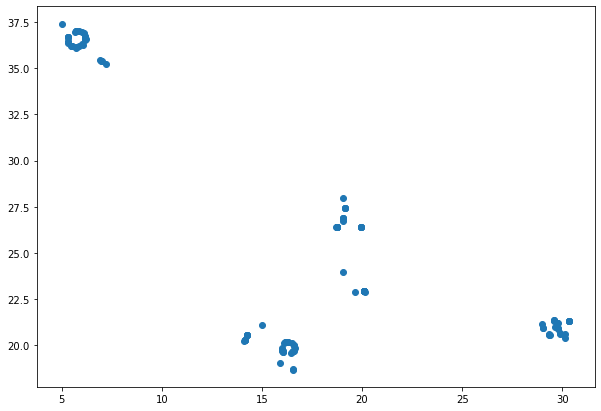

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X_embedded_pro[:, 0], X_embedded_pro[:, 1])

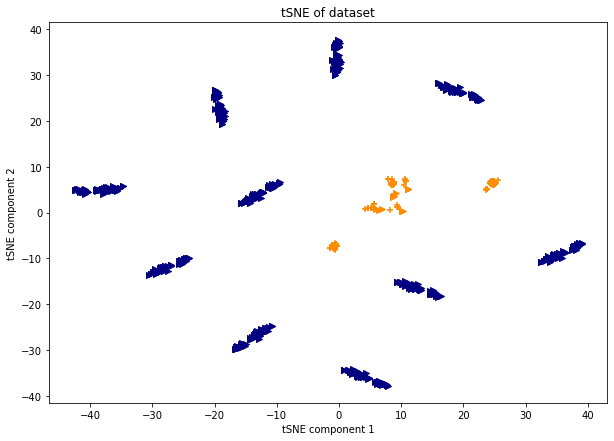

In [21]:
from sklearn.manifold import TSNE
X = np.asarray(frame.iloc[:, :-2])
labels = np.asarray(frame.iloc[:,-3])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
plt.figure(figsize=(10,7))
colors = ["navy", "darkorange"]

for i in range(X_embedded.shape[0]):
    if (frame['origin'][i] == 'prophage') and (labels[i] == 1):
        plt.scatter(X_embedded[i,0], X_embedded[i, 1], color='darkorange', marker='+', label='pos')
    if (frame['origin'][i] == 'prophage') and (labels[i] == 0):
        plt.scatter(X_embedded[i,0], X_embedded[i, 1], color='navy', marker='+', label='neg')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 1):
        plt.scatter(X_embedded[i,0], X_embedded[i, 1], color='darkorange', marker='>', label='pos')
    if (frame['origin'][i] == 'valencia') and (labels[i] == 0):
        plt.scatter(X_embedded[i,0], X_embedded[i, 1], color='navy', marker='>', label='neg')

#X_embedded_val = X_embedded[frame['origin']=='valencia']
#X_embedded_pro = X_embedded[frame['origin']=='prophage']
#labels_val = labels[frame['origin']=='valencia']
#labels_pro = labels[frame['origin']=='prophage']
   
#plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("tSNE of dataset")
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.savefig(results_dir+'/features/all_embeddings_tSNE.png', dpi=400)

## 5 - Processing into structured dataframe for training

In [3]:
def construct_training_dataframe(locus_features, rbp_features, interaction_matrix, RBPbase):
    """
    This function combines the seraparetly computed features of both the locus and the RBPs
    into one array suitable for training, considering the interaction matrix.
    
    At this point, the rows of the featuresets should correspond with the rows and columns of the interaction
    matrix, meaning the interaction matrix should be constructed starting from the same data as the features!
    
    Input:
    - locus features: DataFrame of the features constructed for the bacterial loci (m x #feats)
    - rbp_features: DataFrame of the features constructured for the phage RBPs (n x #feats)
    - interaction matrix: (m x n) with positives (1), negatives (0) and unknown (NaN)
    - RBPbase: RBP dataframe for sanity check (optional)
    """
    
    # define lists to append to
    locus_list = []; rbp_list = []; interaction_list = []; row_list = []; origin_list = []
    
    # loop over interaction matrix and construct dataframe
    for i in range(interaction_matrix.shape[0]):
        for j in range(interaction_matrix.shape[1]):
            interaction = interaction_matrix[i,j]
            
            if math.isnan(interaction) == False:
                # make list of lists, that can subsequently be combined
                locus_list.append(list(locus_features.iloc[i,:]))
                rbp_list.append(list(rbp_features.iloc[j,:]))
                interaction_list.append(int(interaction))
                row_list.append(i)
                origin_list.append(RBPbase['origin'][j])
            
            # sanity check (optional)
            #if (interaction == 1) and (type(RBPbase) !=  int):
            #    locus_id = locus_em.index[i].split('kaptive_results_')[1].split('.fasta')[0]
            #    rbp_id = RBPbase['host_accession'][j]
            #    if locus_id != rbp_id:
            #        print('mismatch!', rbp_id, locus_id)
    
    # concatenate to final dataframe
    training_dataframe = pd.concat([pd.DataFrame(locus_list), pd.DataFrame(rbp_list), pd.DataFrame(interaction_list),
                                    pd.DataFrame({'row': row_list}), pd.DataFrame({'origin': origin_list})], axis=1)
    
    return training_dataframe     

In [4]:
rbpbase = pd.read_csv(klebsiella_dir+'/RBPbase_031221_klebsiella_pneumoniae.csv')
locus_em = pd.read_csv(klebsiella_dir+'/klebsiella_genomes_031221_embeddings.csv', index_col=0)
rbp_em = pd.read_csv(klebsiella_dir+'/RBPbase_031221_klebsiella_pneumoniae_embeddings.csv', index_col=0)
interaction_matrix = np.asarray(pd.read_csv(klebsiella_dir+'/interactions_klebsiella.csv', index_col=0))
interaction_matrix_mono = np.asarray(pd.read_csv(klebsiella_dir+'/interactions_klebsiella_mono.csv', index_col=0))
frame = construct_training_dataframe(locus_em, rbp_em, interaction_matrix_mono, rbpbase)

In [88]:
print('pos:', sum(labels==1), 'negs:', sum(labels==0))

pos:  139 negs: 608


## 6 - Machine learning models <a name="models"></a>

##### Binary classification

In [83]:
# first simple test
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced')
outer_cv = StratifiedKFold(n_splits=4)
score_f1 = make_scorer(f1_score, average='weighted')
frame = np.asarray(frame.iloc[:,:-1])
perf_f1 = cross_val_score(rf, X=frame[:,:-1], y=frame[:,-1], scoring=score_f1, cv=outer_cv, verbose=False)
np.mean(perf_f1)

In [111]:
# grouped K-fold taking into account the loci
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
fscores = []
for train_index, test_index in loci_cv.split(loci_sim):
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    preds = rf.predict(frame_test)
    fscores.append(f1_score(labels_test, preds))
print(fscores, 'mean: ', np.mean(fscores))

In [81]:
# grouped loci K-fold with ranking accuracy
"""
downside is that we make a lot of predictions for out-of-data samples, that we don't know are good or bad...
IDEA: do ranking but then only consider those that are known, and see how high the actual correct one is 
in that ranking.
"""
dim_features_loci = 512
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=6)
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
top10acc = []
for train_index, test_index in loci_cv.split(loci_sim):
    print('new split')
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    test_row_ids = list(set(frame['row'][test_index_frame]))
    pos_sum = 0 # track all positives per cv split to compute accuracy
    correct_preds_sum = 0
    for test_row_index in tqdm(test_row_ids): # loop over test loci
        probs = []
        test_locus_embedding = np.asarray(locus_em.iloc[test_row_index,:]) # locus feats
        positives = [i for i, label in enumerate(labels) if (label == 1) and (frame['row'][i] == test_row_index)]
        pos_sum += len(positives)
        
        # loop over all RBPs
        for rbp_row in range(frame_array.shape[0]):
            test_rbp_embedding = frame_array[rbp_row, dim_features_loci:] # RBP feats
            test_embedding = np.concatenate([test_locus_embedding, test_rbp_embedding]).reshape(1,-1)
            probs.append(rf.predict_proba(test_embedding)[:,1])
        
        # sort probs and get top10 indices
        top10_RBPs = [x for _, x in sorted(zip(probs, range(frame_array.shape[0])), reverse=True)][:10]
        top10_probs = sorted(probs, reverse=True)
        correct_predicted_positives = list(set(top10_RBPs).intersection(positives))
        correct_preds_sum += len(correct_predicted_positives)
    
    # compute top10 accuracy
    top10acc.append(correct_preds_sum/pos_sum)
        
print(top10acc, 'mean: ', np.mean(top10acc))

new split


100%|███████████████████████████████████████████| 37/37 [06:05<00:00,  9.89s/it]


new split


100%|███████████████████████████████████████████| 42/42 [07:02<00:00, 10.06s/it]


new split


100%|███████████████████████████████████████████| 38/38 [06:19<00:00,  9.99s/it]


new split


100%|███████████████████████████████████████████| 40/40 [06:37<00:00,  9.93s/it]


new split


100%|███████████████████████████████████████████| 35/35 [05:48<00:00,  9.95s/it]

[0.025, 0.0, 0.07352941176470588, 0.03333333333333333, 0.04878048780487805] mean:  0.03612864658058346


In [119]:
# RANDOM SHUFFLE LABELS
loci_sim = np.loadtxt(klebsiella_dir+'/kaptive_loci_score_matrix.txt')
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
loci_cv = KFold(n_splits=5, shuffle=True)
frame_array = np.asarray(frame.iloc[:,:-2])
labels = np.asarray(frame.iloc[:,-2])
random.shuffle(labels)
fscores = []
for train_index, test_index in loci_cv.split(loci_sim):
    # construct training and test dataframe
    train_index_frame = []; test_index_frame = []
    for i, row_id in enumerate(frame['row']):
        if row_id in train_index:
            train_index_frame.append(i)
        else:
            test_index_frame.append(i)
    frame_train, frame_test = frame_array[train_index_frame], frame_array[test_index_frame]
    labels_train, labels_test = labels[train_index_frame], labels[test_index_frame]
    
    # fit a model
    rf.fit(frame_train, labels_train)
    
    # make predictions and test
    preds = rf.predict(frame_test)
    fscores.append(f1_score(labels_test, preds))
print(fscores, 'mean: ', np.mean(fscores))

[0.038461538461538464, 0.0, 0.08, 0.04597701149425287, 0.03636363636363636] mean:  0.04016043726388554


##### Structured-output learning

In [37]:
rbpbase = pd.read_csv(data_dir+'/RBPbase_250621_klebsiella_pneumoniae.csv')
locus_em = pd.read_csv(data_dir+'/locus_embeddings.csv', index_col=0)
rbp_em = pd.read_csv(data_dir+'/protein_embeddings.csv', index_col=0)

In [12]:
# k-nearest neighbors for multioutput regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
# create datasets
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=5, random_state=1, noise=0.5)
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X, y)
# make a prediction
row = [0.21947749, 0.32948997, 0.81560036, 0.440956, -0.0606303, -0.29257894, -0.2820059, -0.00290545, 0.96402263, 0.04992249]
yhat = model.predict([row])
# summarize prediction
print(yhat[0])

[121.73740733  31.15853281  98.09647206  67.71553523  41.61800365]


In [106]:
# construct simple X and Y off of the embeddings
X = np.zeros((rbpbase.shape[0], locus_em.shape[1]))
host_names = list(locus_em.index)
for row, host in enumerate(rbpbase['host_accession']):
    index = [i for i, x in enumerate(host_names) if host in x][0]
    X[row, :] = locus_em.iloc[index, :]
    
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Y = pca.fit_transform(rbp_em)

In [107]:
# fit a linear model without jointXY
W1 = np.linalg.inv(np.dot(X.T, X))
W2 = np.dot(X.T, Y)
W = np.dot(W1, W2)

In [110]:
# make predictions & compute naive accuracy
acc = 0
for row in range(X.shape[0]):
    yhat = np.dot(W.T, X[row,:])
    distances = [sum(abs(Y[i,:]-yhat)) for i in range(Y.shape[0])]
    #prediction = distances.index(min(distances))
    preds = np.argsort(distances)[:20]
    if row in preds:
        acc += 1
print('accuracy: ', acc/X.shape[0])

accuracy:  0.0332667997338656


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X, Y)

# make predictions & compute naive accuracy
acc = 0
for row in range(X.shape[0]):
    yhat = model.predict([X[row,:]])
    distances = [sum(abs(Y[i,:]-yhat)) for i in range(Y.shape[0])]
    preds = np.argsort(distances)[:10]
    if row in preds:
        acc += 1
print('accuracy: ', acc/X.shape[0])

In [22]:
jointXY = ...

# fit on the data
W1 = np.linalg.inv(np.dot(jointXY.T, jointXY))
W2 = np.dot(jointXY.T, y)
W = np.dot(W1, W2)

# make preds for new data: for every X in the testset, we construct a jointXY_test
for row in range(Y.shape[1]):
    Yi = Y[row, :]
    

(1000, 5)

## X - Out of use